# LuxonisDatasetFormat - testing embeddings methods

In [1]:
import os

import numpy as np
import onnx
import onnxruntime
import torch
import torch.onnx
import torchvision
from matplotlib import pyplot as plt
from qdrant_client.models import Distance
from utils.data_utils import load_mnist_data

# only for local testing
import sys
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append('/home/paperspace/Luxonis/luxonis-ml')

from luxonis_ml.data import (
    LuxonisDataset,
    LuxonisLoader,
)
from luxonis_ml.embeddings.utils.embedding import (
    extract_embeddings,
    extract_embeddings_onnx,
    load_embeddings,
    save_embeddings,
)
from luxonis_ml.embeddings.utils.ldf import generate_embeddings
from luxonis_ml.embeddings.utils.model import (
    export_model_onnx,
    extend_output_onnx,
    load_model,
    load_model_onnx,
    load_model_resnet50_minuslastlayer,
)
from luxonis_ml.embeddings.utils.qdrant import QdrantAPI, QdrantManager

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch examples

In [2]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [3]:
# Load the model
model = load_model_resnet50_minuslastlayer()

In [4]:
# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, data_loader)

In [5]:
save_embeddings(embeddings, labels)

## ONNX models and Qdrant

In [6]:
# Load the data
data_loader = load_mnist_data(save_path="./mnist", num_samples=640, batch_size=64)

In [7]:
# Load the model
model = load_model()

# Export the model to ONNX
export_model_onnx(model, model_path_out="resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(
    onnx_model, intermediate_tensor_name="/Flatten_output_0"
)

# Save the ONNX model
onnx.save(onnx_model, "resnet50-1.onnx")

In [8]:
# Create an ONNX Runtime session
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(
    ort_session, data_loader, "/Flatten_output_0"
)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels)

2024-01-15 15:15:45.140366441 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [9]:
embeddings, labels = load_embeddings()

In [10]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container2").start_docker_qdrant()

Container is already running.


In [11]:
# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "mnist2")

In [ ]:
# Create a collection
vector_size = embeddings.shape[1]
qdrant_api.create_collection(vector_size=vector_size, distance=Distance.COSINE)

# Insert the embeddings into the collection
# qdrant_api.insert_embeddings(embeddings, labels)
# qdrant_api.insert_embeddings_nooverwrite(embeddings, labels)
qdrant_api.batch_insert_embeddings_nooverwrite(embeddings, labels, batch_size=50)

In [13]:
# Search for the nearest neighbors
search_results = qdrant_api.search_embeddings(embeddings[0], top=5)

# Print the search results
print(np.array(search_results))

[ScoredPoint(id=530, version=10, score=1.0, payload={'label': 3}, vector=None)
 ScoredPoint(id=63, version=1, score=0.97092855, payload={'label': 3}, vector=None)
 ScoredPoint(id=460, version=9, score=0.96763027, payload={'label': 2}, vector=None)
 ScoredPoint(id=262, version=5, score=0.96572876, payload={'label': 3}, vector=None)
 ScoredPoint(id=491, version=9, score=0.96498007, payload={'label': 2}, vector=None)]


## LuxonisDatasetFormat, ONNX and Qdrant

In [15]:
NUM_SAMPLES = 6400  # -1 # minus one is equivalent to all samples
BATCH_SIZE = 64

In [16]:
# Load the MNIST data
data_loader = load_mnist_data(
    save_path="./mnist", num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE
)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")

Number of samples: 6400


In [18]:
# Create a tmp directory to store the images
mnist_image_dir = "./mnist_images"
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)

In [19]:
# Convert MNIST data to Luxonis ML format
def mnist_LDF_generator():
    batch_num = 0
    for batch in data_loader:
        images, labels = batch
        for i, (image, label) in enumerate(zip(images, labels)):
            img_ix = batch_num * BATCH_SIZE + i

            # Save image to disk
            image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
            torchvision.utils.save_image(image, image_path)

            # Create dictionary structure for Luxonis ML
            yield {
                "file": image_path,
                "class": str(label.item()),
                "type": "classification",
                "value": True,
            }
        batch_num += 1


In [20]:
# 2. Load the MNIST Data into LDF
dataset_name = "mnist_dataset6"

# Create a new dataset in LDF
dataset = LuxonisDataset(dataset_name)

In [21]:
# Add the MNIST data to the dataset
dataset.set_classes(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
dataset.add(mnist_LDF_generator)
dataset.make_splits()

100%|██████████| 6400/6400 [00:00<00:00, 18820.23it/s]


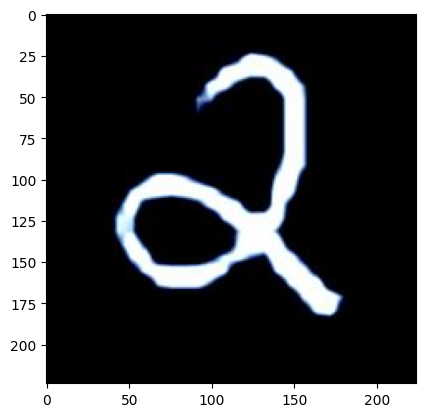

In [22]:
loader = LuxonisLoader(dataset)
for img, _ in loader:
    plt.imshow(img)
    plt.show()
    break

In [23]:
# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

2024-01-15 15:16:11.463624670 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [28]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container2").start_docker_qdrant()

# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333, "mnist4")

# Create a collection
qdrant_api.create_collection(vector_size=2048, distance=Distance.COSINE)

Container is already running.
Created new collection


/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/httpx/_content.py:204: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


In [ ]:
# Load the LuxonisDataset
emb_dict = generate_embeddings(
    dataset, ort_session, qdrant_api, output_layer_name="/Flatten_output_0"
)

In [32]:
first_emb = None

# get a specific sample from dataset
first_sample = list(emb_dict.keys())[0]
first_emb = emb_dict[first_sample]
sample_id = first_sample

# sample_id = '64e758bdca1096d3483d18f4'
# sample = dataset.fo_dataset[sample_id]
df = dataset._load_df_offline()
sample = df[df["instance_id"] == sample_id]
print(sample)

          file class            type value  \
0  mnist_0.jpg     3  classification  True   

                            instance_id value_type                 created_at  
0  5c86ce37-2e4c-5949-acc2-6ceeb37373d5       bool 2024-01-15 15:16:10.849208  


In [33]:
# Search for the nearest neighbors
search_results = qdrant_api.search_embeddings(np.array(first_emb), top=5)
print(np.array(search_results))

[ScoredPoint(id='5c86ce37-2e4c-5949-acc2-6ceeb37373d5', version=0, score=1.0, payload={'class': '3', 'image_path': '/home/paperspace/Luxonis/luxonis-ml/examples/mnist_images/mnist_0.jpg', 'instance_id': '5c86ce37-2e4c-5949-acc2-6ceeb37373d5'}, vector=None)
 ScoredPoint(id='722c4d18-d30e-54a8-92df-391952d9b1b9', version=4, score=0.9844011, payload={'class': '3', 'image_path': '/home/paperspace/Luxonis/luxonis-ml/examples/mnist_images/mnist_295.jpg', 'instance_id': '722c4d18-d30e-54a8-92df-391952d9b1b9'}, vector=None)
 ScoredPoint(id='6e8eb47d-493c-518e-89de-a7c8dacb7b59', version=92, score=0.9841205, payload={'class': '3', 'image_path': '/home/paperspace/Luxonis/luxonis-ml/examples/mnist_images/mnist_5944.jpg', 'instance_id': '6e8eb47d-493c-518e-89de-a7c8dacb7b59'}, vector=None)
 ScoredPoint(id='f378525c-023e-534a-8209-edd7c776c026', version=24, score=0.982066, payload={'class': '3', 'image_path': '/home/paperspace/Luxonis/luxonis-ml/examples/mnist_images/mnist_1586.jpg', 'instance_id':

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/httpx/_content.py:204: DeprecationWarning: Use 'content=<...>' to upload raw bytes/text content.
  warnings.warn(message, DeprecationWarning)


## Embeddings Processing

In [ ]:
# look at the Embeddings_Processing_Example.ipynb for the rest of the code

## Remove everything

In [ ]:
# ! rm -rf ./mnist_images
# ! rm -rf ./mnist
# ! rm ./resnet50.onnx
# ! rm ./resnet50-1.onnx
# ! rm ./embeddings.pth
# ! rm ./labels.pth


In [ ]:

# # # Stop the Qdrant Docker container
# # stop_docker_qdrant()

# # Delete the Qdrant collection
# qdrant_client.delete_collection(collection_name="mnist2")
# qdrant_client.delete_collection(collection_name="mnist3")

In [ ]:
# # Delete the Luxonis ML dataset

# dataset.delete_dataset()